## Gaussian mixture reduction example on `M100`

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

/Users/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/mavillan/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


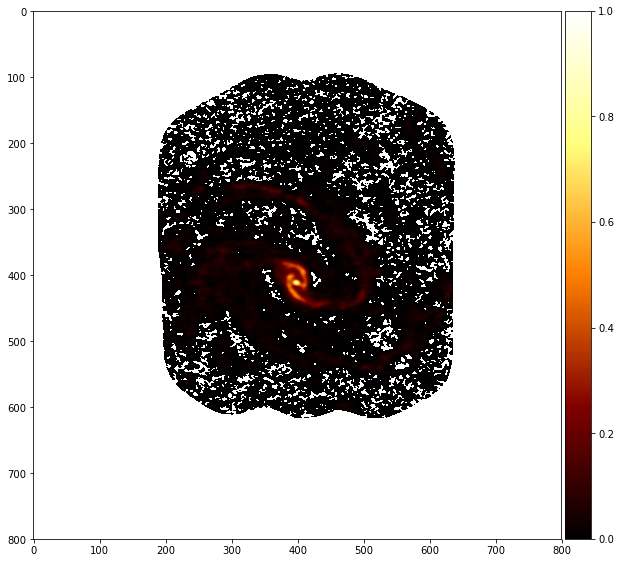

In [3]:
"""
Loading data
"""
#fits_path = '../../data/images/Orion.cont.image.fits'
fits_path = '../../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data, title='')

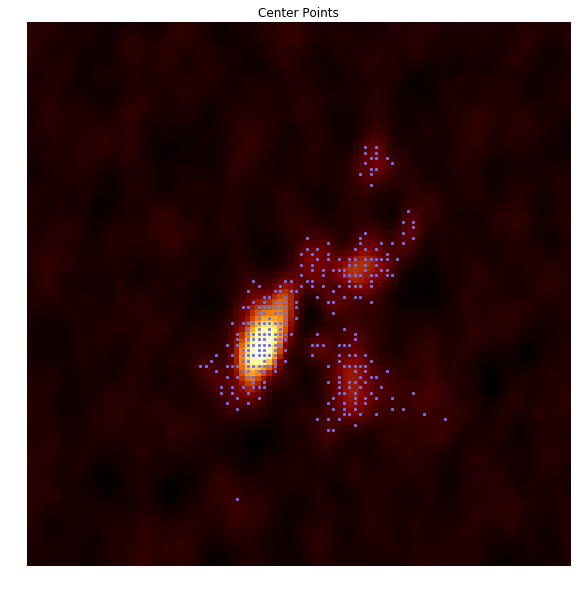

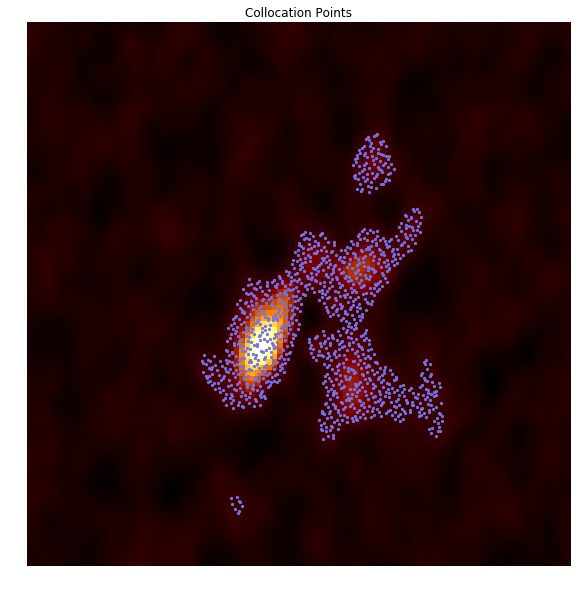

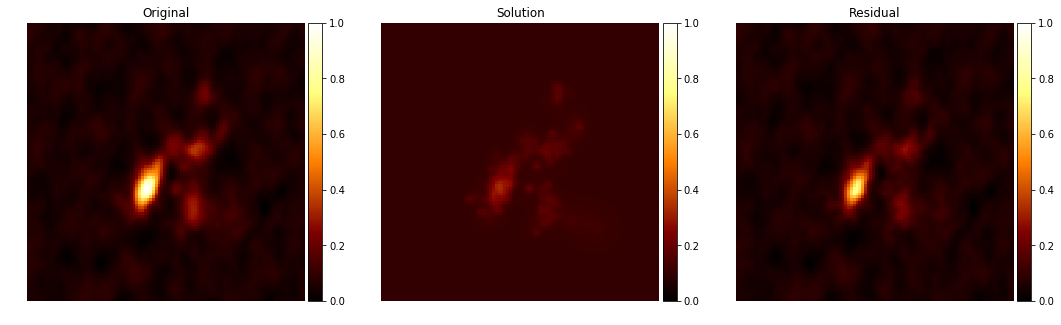

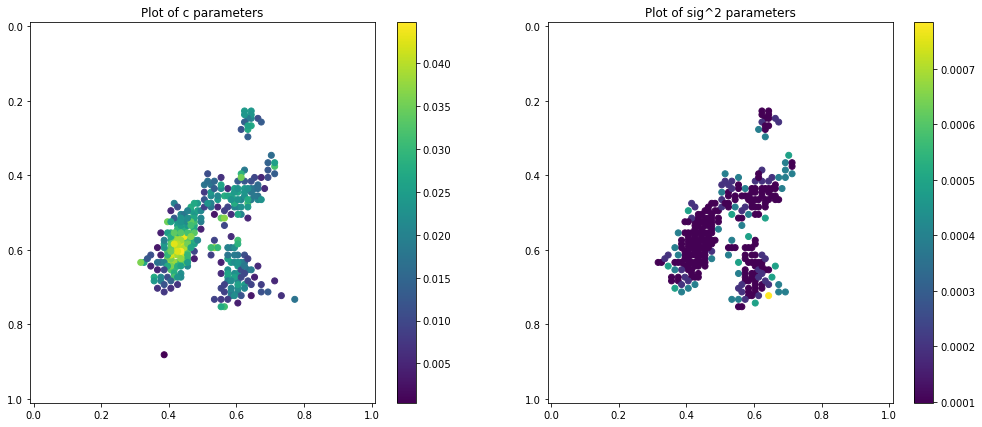

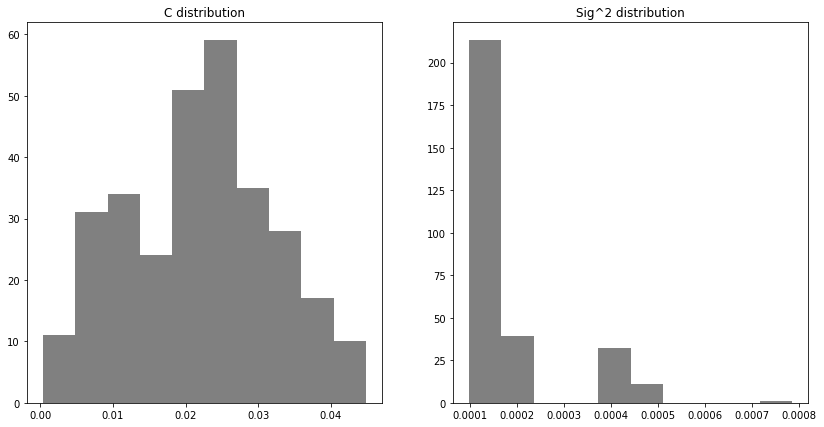

In [55]:
##########################################
#### Approach 1
##########################################
base_level = estimate_rms(data)

Nc = 300
Nb = 0
Ne = 4*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=5.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 160100.
nfev: 160107

Residual stats:
Residual RMS: 0.048588917158421036
Residual Variance: 0.00028040352802714656
Residual Entropy: 4.6850248450781145
Total elapsed time: 857.400548696518 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26038974193151904
Mean min distance between collocation and center points: 0.011740125884775982

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.04311164894680414
Max min distance in the (standarized) parameters space: 0.28549409290871514


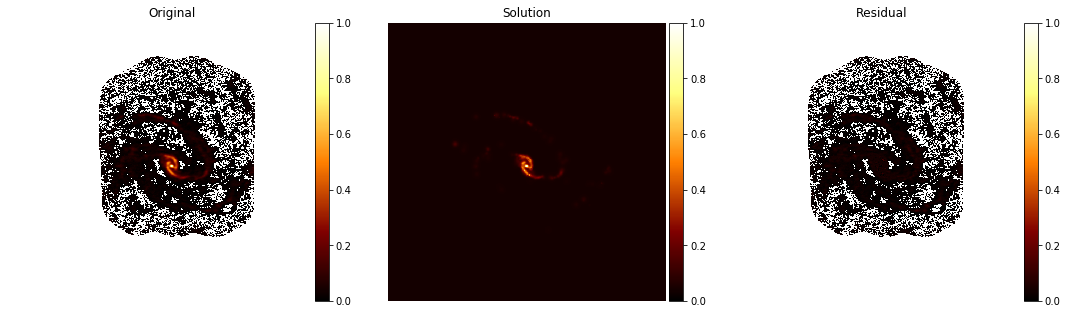

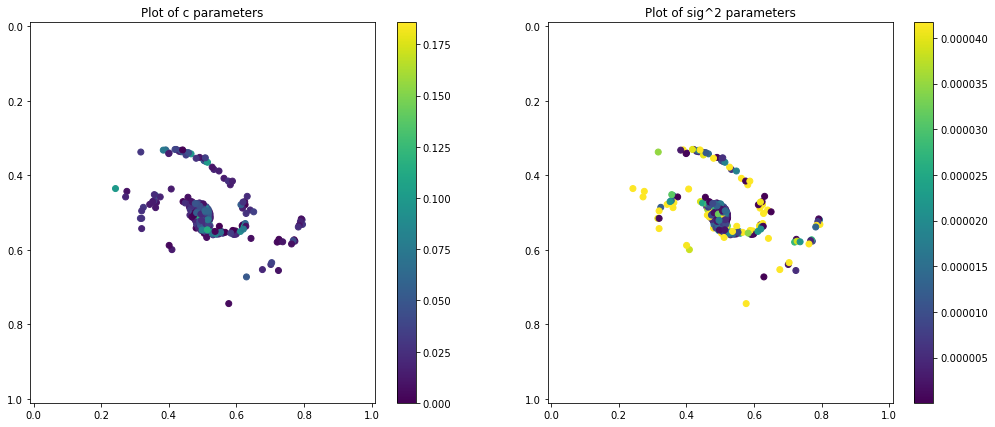

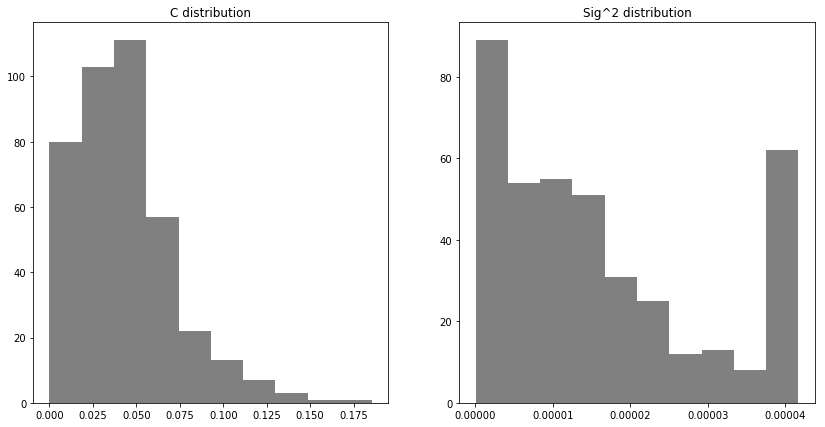

In [40]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [42]:
#extracting parameters
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

#performing GMR
components_dict = gaussian_reduction(w, mu, sig, n_comp=1, metric=KL_dissimilarity, verbose=False)

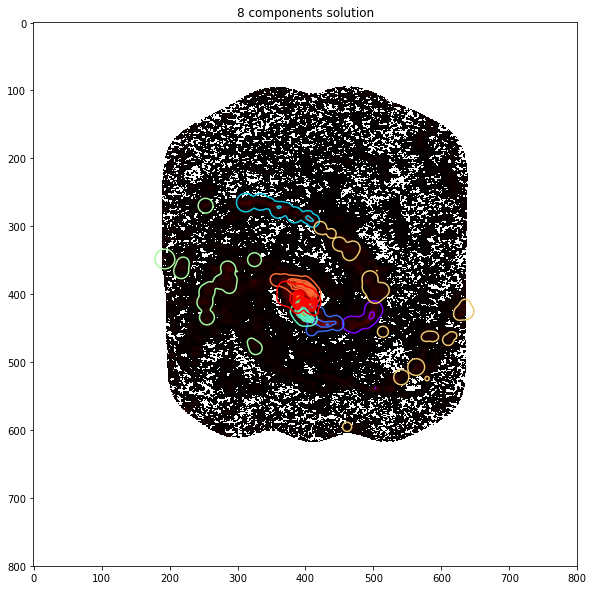

In [51]:
components_plot(elm01, components_dict, n_comp=8, n_levels=10)